In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.rc('text',usetex=True)

In [2]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path):
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    print('total number:',sum(n_combine))
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err)

## Play with MCMC

In [3]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


## Sersic + NFW model

In [4]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic
    
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    
    return nfw_val + sersic_val

from scipy.optimize import curve_fit
def fit_nfw_sersic(xdata, ydata, ydata_err):
    start = 4
    popt,pcov = curve_fit(nfw_sersic, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:], p0=[300,4e-5,1e-5,13.1, 5.5]
                          ,bounds=([1, 0, 0 ,0.1 ,1],[10000, 1e-3, 1e-3, 100, 10]))
    return popt,pcov

def fit_nfw(xdata, ydata, ydata_err):
    start = 4
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    return popt,pcov

## Power Law

In [5]:
def power_law(r, I, a):
    
    return I*r**a

from scipy.optimize import curve_fit
def fit_power(xdata, ydata, ydata_err):
    start = 4
    popt,pcov = curve_fit(power_law,xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    return popt,pcov

## Total Satellite Sample

In [87]:
# Number Surface Density Plot

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/'
count_radial_4 = combine_deep('all','all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep('all','all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep('all','all','9.5','13.0',0.8,path)
bin_edges = np.load(path+'bin_centers.npy')

power_law_model = pm.Model()

X = np.log10(bin_edges[3:])
Y = np.log10(count_radial_4[0][3:])

print(X)
print(Y)
with power_law_model: 
    # Priors for unknown model parameters
    a = pm.Normal('a', mu=-1, sd=0.2)
    I = pm.Normal('I', mu=0.001, sd=1)
    sigma = pm.HalfNormal('sigma', sd=2)

    # Expected value of outcome
    mu = I+a*X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

map_estimate = pm.find_MAP(model=power_law_model)
print('a',map_estimate['a'])
print('I',map_estimate['I'])

a_best = map_estimate['a']
I_best = map_estimate['I']

with power_law_model:
    # draw 500 posterior samples
    step = pm.Slice()
    trace = pm.sample(5000,step=step)

total number: 1089
total number: 1393
total number: 2570
[1.46602853 1.59997968 1.72865202 1.8628794  1.99198256 2.12387231
 2.25955937 2.39250882 2.5234606  2.65328849 2.7870177 ]
[-3.97900518 -4.04358166 -4.21542033 -4.47914176 -4.58980708 -4.72448976
 -4.86315085 -4.97980319 -5.11408524 -5.32987619 -5.63347233]


logp = 11.61, ||grad|| = 0.00010522: 100%|██████████| 32/32 [00:00<00:00, 1694.22it/s]  


a -1.196157265064343
I -2.1788339780874493


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [I]
>Slice: [a]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:09<00:00, 2218.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


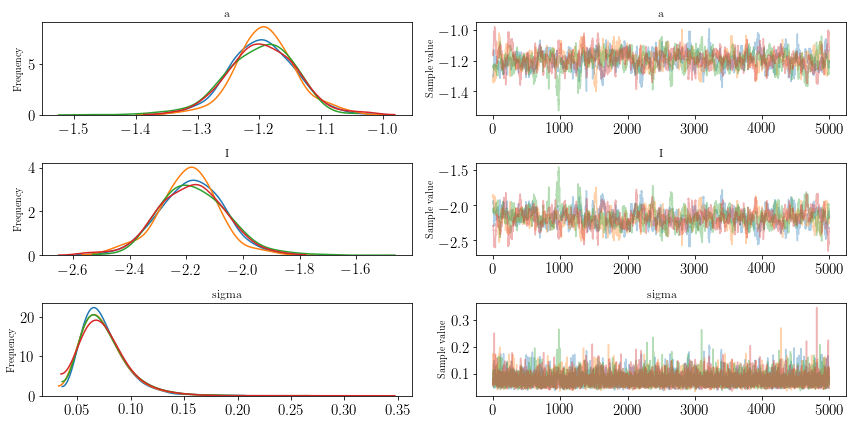

In [90]:
pm.traceplot(trace)
plt.show()

0.006624697039428525 -1.196157265064343


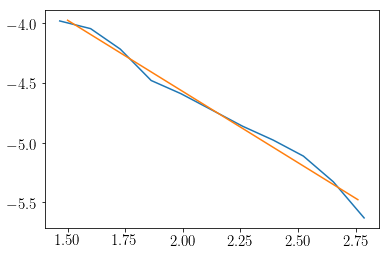

In [91]:
plt.plot(X,Y)
print(10**I_best,a_best)
x = np.linspace(1.5,2.76,100)
plt.plot(x,I_best+a_best*x)

plt.show()

total number: 1089
total number: 1393
total number: 2570
fitting power law
fitting NFW+Sersic
[2.47292568e+02 2.95340017e-05 5.81860558e-05 3.01900284e+01
 1.00000000e+00]
[1.97744380e+02 3.34404568e-05 4.84936549e-05 2.93627997e+01
 1.00000000e+00]
[3.38783875e+02 1.97384602e-05 9.80160077e-05 1.97209951e+01
 1.00000000e+00]


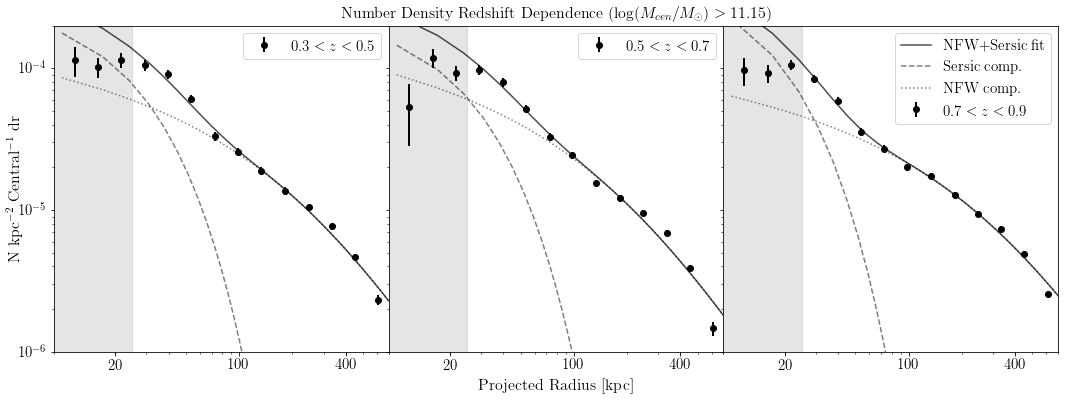

In [93]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/'
count_radial_4 = combine_deep('all','all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep('all','all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep('all','all','9.5','13.0',0.8,path)
bin_edges = np.load(path+'bin_centers.npy')
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#=========
fit_x = np.linspace(10,700,num=100)

# Power Law Fitting
print('fitting power law')

# popt4,pocv4 = fit_power(bin_edges,count_radial_4[0],count_radial_4[1])
# popt6,pocv6 = fit_power(bin_edges,count_radial_6[0],count_radial_6[1])
# popt8,pocv8 = fit_power(bin_edges,count_radial_8[0],count_radial_8[1])

# axs[0].plot(fit_x,power_law(fit_x, popt4[0],popt4[1]),'k',alpha=0.7)
# axs[1].plot(fit_x,power_law(fit_x, popt6[0],popt6[1]),'k',alpha=0.7)
# axs[2].plot(fit_x,power_law(fit_x, popt8[0],popt8[1]),'k',alpha=0.7,label='Power law fit')

# NFW Fitting
# print('fitting NFW')
# popt4,pocv4 = fit_nfw(bin_edges,count_radial_4[0],count_radial_4[1])
# popt6,pocv6 = fit_nfw(bin_edges,count_radial_6[0],count_radial_6[1])
# popt8,pocv8 = fit_nfw(bin_edges,count_radial_8[0],count_radial_8[1])

# axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),'k',alpha=0.5)
# axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),'k',alpha=0.5)
# axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),'k',alpha=0.5,label='NFW fit')

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
popt4,pocv4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1])
popt6,pocv6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1])
popt8,pocv8 = fit_nfw_sersic(bin_edges,count_radial_8[0],count_radial_8[1])

axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),'k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),'k',alpha=0.7,label='NFW+Sersic fit')

axs[0].plot(fit_x,sersic(fit_x, popt4[2],popt4[3],popt4[4]),'--k',alpha=0.5)
axs[1].plot(fit_x,sersic(fit_x, popt6[2],popt6[3],popt6[4]),'--k',alpha=0.5)
axs[2].plot(fit_x,sersic(fit_x, popt8[2],popt8[3],popt8[4]),'--k',alpha=0.5,label='Sersic comp.')

axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),':k',alpha=0.5)
axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),':k',alpha=0.5)
axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')

print(popt4)
print(popt6)
print(popt8)
#=========

axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([1e-6,2e-4])

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=16)
plt.title('Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.savefig('figures/number_density_zdependence.png')
plt.show() 

## Split for Satellite Mass

In [ ]:
bin_number = 14
bin_edges = 10 ** np.linspace(1, 2.845, num=bin_number+1)
areas = np.array([])
for i in range(len(bin_edges[:-1])):
    areas = np.append(areas, (bin_edges[i + 1] ** 2 - bin_edges[i] ** 2) * np.pi)

In [ ]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to vaoid bad behavior form plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

In [ ]:
path = 'CUT_deep_catalogs/split_sat_mass_new/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

radial_3_sf_85 = combine_deep('all','ssf','8.5','9.0',0.3,path=path)
radial_3_sf_l = combine_deep('all','ssf','9.0','9.5',0.3,path=path)
radial_3_sf_m = combine_deep('all','ssf','9.5','10.2',0.3,path=path)
radial_3_sf_h = combine_deep('all','ssf','10.2','inf',0.3,path=path)
radial_3_q_85 = combine_deep('all','sq','8.5','9.0',0.3,path=path)
radial_3_q_l = combine_deep('all','sq','9.0','9.5',0.3,path=path)
radial_3_q_m = combine_deep('all','sq','9.5','10.2',0.3,path=path)
radial_3_q_h = combine_deep('all','sq','10.2','inf',0.3,path=path)

radial_6_sf_l = combine_deep('all','ssf','9.0','9.5',0.6,path=path)
radial_6_sf_m = combine_deep('all','ssf','9.5','10.2',0.6,path=path)
radial_6_sf_h = combine_deep('all','ssf','10.2','inf',0.6,path=path)
radial_6_q_l = combine_deep('all','sq','9.0','9.5',0.6,path=path)
radial_6_q_m = combine_deep('all','sq','9.5','10.2',0.6,path=path)
radial_6_q_h = combine_deep('all','sq','10.2','inf',0.6,path=path)

radial_3_85 = combine_deep('all','all','8.5','9.0',0.3,path=path)
radial_3_l = combine_deep('all','all','9.0','9.5',0.3,path=path)
radial_6_l = combine_deep('all','all','9.0','9.5',0.6,path=path)
radial_3_m = combine_deep('all','all','9.5','10.2',0.3,path=path)
radial_6_m = combine_deep('all','all','9.5','10.2',0.6,path=path)
radial_3_h = combine_deep('all','all','10.2','inf',0.3,path=path)
radial_6_h = combine_deep('all','all','10.2','inf',0.6,path=path)
print(radial_3_sf_85)
redfrac_err_3_85 = red_frac_err(radial_3_q_85[0],radial_3_sf_85[0],radial_3_q_85[1],radial_3_sf_85[1])
redfrac_err_3_l = red_frac_err(radial_3_q_l[0],radial_3_sf_l[0],radial_3_q_l[1],radial_3_sf_l[1])
redfrac_err_6_l = red_frac_err(radial_6_q_l[0],radial_6_sf_l[0],radial_6_q_l[1],radial_6_sf_l[1])
redfrac_err_3_m = red_frac_err(radial_3_q_m[0],radial_3_sf_m[0],radial_3_q_m[1],radial_3_sf_m[1])
redfrac_err_6_m = red_frac_err(radial_6_q_m[0],radial_6_sf_m[0],radial_6_q_m[1],radial_6_sf_m[1])
redfrac_err_3_h = red_frac_err(radial_3_q_h[0],radial_3_sf_h[0],radial_3_q_h[1],radial_3_sf_h[1])
redfrac_err_6_h = red_frac_err(radial_6_q_h[0],radial_6_sf_h[0],radial_6_q_h[1],radial_6_sf_h[1])

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(3, 4, sharex=True, sharey='row', figsize = (20, 13.5),gridspec_kw={'height_ratios':[4,4,1]})
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

#====================Radial Distribution ===================

# Total curves
axs[0][0].errorbar(bin_edges, radial_3_85[0], yerr=None, fmt='k',linewidth=2)
axs[0][0].fill_between(bin_edges,radial_3_85[0]+radial_3_85[1], 
                       aa(radial_3_85[0]-radial_3_85[1]), alpha=0.2, color='k')

axs[0][1].errorbar(bin_edges, radial_3_l[0], yerr=None, fmt='k',linewidth=2)
axs[0][1].fill_between(bin_edges,radial_3_l[0]+radial_3_l[1], 
                       aa(radial_3_l[0]-radial_3_l[1]), alpha=0.2, color='k')

axs[0][2].errorbar(bin_edges, radial_3_m[0], yerr=None, fmt='k',linewidth=2)
axs[0][2].fill_between(bin_edges,radial_3_m[0]+radial_3_m[1], 
                       aa(radial_3_m[0]-radial_3_m[1]), alpha=0.2, color='k')

axs[0][3].errorbar(bin_edges, radial_3_h[0], yerr=None,fmt='k',label='total')
axs[0][3].fill_between(bin_edges,radial_3_h[0]+radial_3_h[1], 
                       aa(radial_3_h[0]-radial_3_h[1]), alpha=0.2, color='k')

axs[1][1].errorbar(bin_edges, radial_6_l[0], yerr=None, fmt='--k',linewidth=2)
axs[1][1].fill_between(bin_edges,radial_6_l[0]+radial_6_l[1], 
                       aa(radial_6_l[0]-radial_6_l[1]), alpha=0.2, color='k')

axs[1][2].errorbar(bin_edges, radial_6_m[0], yerr=None, fmt='--k',linewidth=2)
axs[1][2].fill_between(bin_edges,radial_6_m[0]+radial_6_m[1], 
                       aa(radial_6_m[0]-radial_6_m[1]), alpha=0.2, color='k')

axs[1][3].errorbar(bin_edges, radial_6_h[0], yerr=None,fmt='--k')
axs[1][3].fill_between(bin_edges,radial_6_h[0]+radial_6_h[1], 
                       aa(radial_6_h[0]-radial_6_h[1]), alpha=0.2, color='k')

# Star Forming curves
axs[0][0].errorbar(bin_edges, radial_3_sf_85[0], yerr=None, fmt='b',linewidth=2)
axs[0][0].fill_between(bin_edges,radial_3_sf_85[0]+radial_3_sf_85[1], 
                       aa(radial_3_sf_85[0]-radial_3_sf_85[1]), alpha=0.2, color='b')
axs[0][0].set_xlabel('Projected Radius [kpc]', fontsize=14)
axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=14)
axs[0][0].set_title(r'8.5<$\log(M/M_\odot)<9.0$',fontsize=14)

axs[0][1].errorbar(bin_edges, radial_3_sf_l[0], yerr=None, fmt='b',label='z=0.3',linewidth=2)
axs[1][1].errorbar(bin_edges, radial_6_sf_l[0], yerr=None, fmt='--b',label='z=0.6',linewidth=2)
axs[0][1].fill_between(bin_edges,radial_3_sf_l[0]+radial_3_sf_l[1], 
                       aa(radial_3_sf_l[0]-radial_3_sf_l[1]), alpha=0.2, color='b')
axs[1][1].fill_between(bin_edges,radial_6_sf_l[0]+radial_6_sf_l[1], 
                       aa(radial_6_sf_l[0]-radial_6_sf_l[1]), alpha=0.2, color='b')
axs[0][1].set_title(r'9.0<$\log(M/M_\odot)$<9.5',fontsize=14)

axs[0][2].errorbar(bin_edges, radial_3_sf_m[0], yerr=None, fmt='b',linewidth=2)
axs[1][2].errorbar(bin_edges, radial_6_sf_m[0], yerr=None, fmt='--b',linewidth=2)

axs[0][2].fill_between(bin_edges,radial_3_sf_m[0]+radial_3_sf_m[1], 
                       aa(radial_3_sf_m[0]-radial_3_sf_m[1]), alpha=0.2, color='b')
axs[1][2].fill_between(bin_edges,radial_6_sf_m[0]+radial_6_sf_m[1], 
                       aa(radial_6_sf_m[0]-radial_6_sf_m[1]), alpha=0.2, color='b')

axs[0][2].set_xlabel('Projected Radius [kpc]', fontsize=14)
axs[0][2].set_title(r'9.50<$\log(M/M_\odot)$<10.2',fontsize=14)

axs[0][3].errorbar(bin_edges, radial_3_sf_h[0], yerr=None,fmt='b',label='sf')
axs[1][3].errorbar(bin_edges, radial_6_sf_h[0], yerr=None,fmt='--b')
axs[0][3].fill_between(bin_edges,radial_3_sf_h[0]+radial_3_sf_h[1], 
                       aa(radial_3_sf_h[0]-radial_3_sf_h[1]), alpha=0.2, color='b')
axs[1][3].fill_between(bin_edges,radial_6_sf_h[0]+radial_6_sf_h[1], 
                       aa(radial_6_sf_h[0]-radial_6_sf_h[1]), alpha=0.2, color='b')
axs[0][3].set_title(r'10.2<$\log(M/M_\odot)$',fontsize=14)
axs[0][3].legend(fontsize=14)


# Quiescent Curves
axs[0][0].errorbar(bin_edges, radial_3_q_85[0], yerr=None,fmt='r')
axs[0][0].fill_between(bin_edges,radial_3_q_85[0]+radial_3_q_85[1], 
                       aa(radial_3_q_85[0]-radial_3_q_85[1]), alpha=0.2, color='r')

axs[0][1].errorbar(bin_edges, radial_3_q_l[0], yerr=None,fmt='r')
axs[1][1].errorbar(bin_edges, radial_6_q_l[0], yerr=None,fmt='--r')
axs[0][1].fill_between(bin_edges,radial_3_q_l[0]+radial_3_q_l[1], 
                       aa(radial_3_q_l[0]-radial_3_q_l[1]), alpha=0.2, color='r')
axs[1][1].fill_between(bin_edges,radial_6_q_l[0]+radial_6_q_l[1], 
                       aa(radial_6_q_l[0]-radial_6_q_l[1]), alpha=0.2, color='r')
axs[0][1].legend(fontsize=14)

axs[0][2].errorbar(bin_edges, radial_3_q_m[0], yerr=None,fmt='r',linewidth=2)
axs[1][2].errorbar(bin_edges, radial_6_q_m[0], yerr=None,fmt='--r',linewidth=2)
axs[0][2].fill_between(bin_edges,radial_3_q_m[0]+radial_3_q_m[1], 
                       aa(radial_3_q_m[0]-radial_3_q_m[1]), alpha=0.2, color='r')
axs[1][2].fill_between(bin_edges,radial_6_q_m[0]+radial_6_q_m[1], 
                       aa(radial_6_q_m[0]-radial_6_q_m[1]), alpha=0.2, color='r')

axs[0][3].errorbar(bin_edges, radial_3_q_h[0], yerr=None,fmt='r',label='q',linewidth=2)
axs[1][3].errorbar(bin_edges, radial_6_q_h[0], yerr=None,fmt='--r',linewidth=2)
axs[0][3].fill_between(bin_edges,radial_3_q_h[0]+radial_3_q_h[1], 
                       aa(radial_3_q_h[0]-radial_3_q_h[1]), alpha=0.2, color='r')
axs[1][3].fill_between(bin_edges,radial_6_q_h[0]+radial_6_q_h[1], 
                       aa(radial_6_q_h[0]-radial_6_q_h[1]), alpha=0.2, color='r')
axs[0][3].legend(fontsize=14)

axs[0][0].set_ylim([1e-8,1e-4])
axs[0][0].set_xlim([8,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')

axs[1][0].set_ylim([1e-8,1e-4])
axs[1][0].set_yscale('log')
axs[1][0].set_xscale('log')
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#================Red Fraction========================
axs[2][0].errorbar(bin_edges, radial_3_q_l[0]/(radial_3_sf_85[0]+radial_3_q_85[0]),fmt='k',yerr=redfrac_err_3_85)

axs[2][0].set_ylabel('Red Fraction',fontsize=14)

axs[2][1].errorbar(bin_edges, radial_3_q_l[0]/(radial_3_sf_l[0]+radial_3_q_l[0]),fmt='k',yerr=redfrac_err_3_l,label='z=0.3')
axs[2][1].errorbar(bin_edges, radial_6_q_l[0]/(radial_6_sf_l[0]+radial_6_q_l[0]),fmt='--k',yerr=redfrac_err_6_l,label='z=0.6')

axs[2][1].legend(fontsize=14)
axs[2][1].set_ylim([0,1])

axs[2][2].errorbar(bin_edges, radial_3_q_m[0]/(radial_3_sf_m[0]+radial_3_q_m[0]),fmt='k',yerr=redfrac_err_3_m)
axs[2][2].errorbar(bin_edges, radial_6_q_m[0]/(radial_6_sf_m[0]+radial_6_q_m[0]),fmt='--k',yerr=redfrac_err_6_m)

axs[2][3].errorbar(bin_edges, radial_3_q_h[0]/(radial_3_sf_h[0]+radial_3_q_h[0]),fmt='k',yerr=redfrac_err_3_h)
axs[2][3].errorbar(bin_edges, radial_6_q_h[0]/(radial_6_sf_h[0]+radial_6_q_h[0]),fmt='--k',yerr=redfrac_err_6_h)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_mass_redfraction.png')
plt.show()

## Galaxy Conformity

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

path = 'CUT_deep_catalogs/conformity/'
radial_csf_ssf_6 = combine_deep('csf','ssf','9.5','inf',0.6, path)
radial_csf_sq_6 = combine_deep('csf','sq','9.5','inf',0.6, path)
radial_cq_ssf_6 = combine_deep('cq','ssf','9.5','inf',0.6, path)
radial_cq_sq_6 = combine_deep('cq','sq','9.5','inf',0.6, path)
radial_csf_6 = combine_deep('csf','all','9.5','inf',0.6, path)
radial_cq_6 = combine_deep('cq','all','9.5','inf',0.6, path)

redfrac_err_csf_6 = red_frac_err(radial_csf_sq_6[0],radial_csf_ssf_6[0],radial_csf_sq_6[1],radial_csf_ssf_6[1])
redfrac_err_cq_6 = red_frac_err(radial_cq_sq_6[0],radial_cq_ssf_6[0],radial_cq_sq_6[1],radial_cq_ssf_6[1])

bin_centers = np.load(path+'bin_centers.npy')

axs[0][0].errorbar(bin_centers, radial_csf_ssf_6[0], fmt='b',label='sf')
axs[0][0].errorbar(bin_centers, radial_csf_sq_6[0], fmt='r',label='q')
axs[0][0].errorbar(bin_centers, radial_csf_6[0], yerr=None, fmt='k',label='total')
axs[0][0].fill_between(bin_centers,radial_csf_ssf_6[0]+radial_csf_ssf_6[1], 
                       radial_csf_ssf_6[0]-radial_csf_ssf_6[1], alpha=0.3,color='b')
axs[0][0].fill_between(bin_centers,radial_csf_sq_6[0]+radial_csf_sq_6[1], 
                       radial_csf_sq_6[0]-radial_csf_sq_6[1], alpha=0.3,color='r')
axs[0][0].fill_between(bin_centers,radial_csf_6[0]+radial_csf_6[1], 
                       radial_csf_6[0]-radial_csf_6[1], alpha=0.3,color='k')

axs[0][0].legend(fontsize=14)

axs[0][1].errorbar(bin_centers, radial_cq_ssf_6[0], yerr=None, fmt='b')
axs[0][1].errorbar(bin_centers, radial_cq_sq_6[0], yerr=None, fmt='r')
axs[0][1].errorbar(bin_centers, radial_cq_6[0], yerr=None, fmt='k')
axs[0][1].fill_between(bin_centers,radial_cq_ssf_6[0]+radial_cq_ssf_6[1], 
                       radial_cq_ssf_6[0]-radial_cq_ssf_6[1], alpha=0.3,color='b')
axs[0][1].fill_between(bin_centers,radial_cq_sq_6[0]+radial_cq_sq_6[1], 
                       radial_cq_sq_6[0]-radial_cq_sq_6[1], alpha=0.3,color='r')
axs[0][1].fill_between(bin_centers,radial_cq_6[0]+radial_cq_6[1], 
                       radial_cq_6[0]-radial_cq_6[1], alpha=0.3,color='k')


axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=14)
axs[0][0].set_title('Star-forming Central',fontsize=15)
axs[0][1].set_title('Quiescent Central',fontsize=15)

axs[1][0].errorbar(bin_centers, radial_csf_sq_6[0]/(radial_csf_sq_6[0]+radial_csf_ssf_6[0]),fmt='k',yerr=redfrac_err_csf_6,label='z=0.6')
axs[1][1].errorbar(bin_centers, radial_cq_sq_6[0]/(radial_cq_sq_6[0]+radial_cq_ssf_6[0]),fmt='k',yerr=redfrac_err_cq_6)
axs[1][0].set_ylabel('Red Fraction',fontsize=14)
axs[1][0].legend(fontsize=14)
axs[1][0].set_ylabel('Red Fraction', fontsize=14)
# axs[1][0].set_yscale('log').

# popt_csf = fit_nfw_sersic(bin_edges,radial_csf_6[0],radial_csf_6[1])
# popt_cq = fit_nfw_sersic(bin_edges,radial_cq_6[0],radial_cq_6[1])


# axs[0][0].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_csf[0],popt_csf[1],popt_csf[2],popt_csf[3])
#                ,'--k',alpha=0.7,label='NFW fit')
# axs[0][1].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_cq[0],popt_cq[1],popt_cq[2],popt_cq[3]),'--k',alpha=0.7,label='NFW fit')

axs[0][0].set_ylim([3e-7,2e-4])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_central_sfq_0.6.png')
plt.show()

In [ ]:
from scipy.stats import ks_2samp
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

cat = Table.read('CUT_deep_catalogs/massive_gal_positions/isolated_COSMOS_deep_11.15_0.6.positions.fits')

cat_sf = cat[cat['ssfr']>-11]
cat_q = cat[cat['ssfr']<-11]
weights_sf = np.ones_like(cat_sf['mass'])/float(len(cat_sf))
weights_q = np.ones_like(cat_q['mass'])/float(len(cat_q))

n_sf,bin_edges, pathces = plt.hist(cat_sf['mass'],weights=weights_sf,bins=np.arange(11.15,12.35,0.05),
         histtype='step',linewidth=2, color='b',label='sf: '+str(len(cat_sf['mass'])))
n_q,bin_edges, pathces =plt.hist(cat_q['mass'],weights=weights_q,bins=np.arange(11.15,12.35,0.05),
         histtype='step',linewidth=2, color='r',label='q: '+str(len(cat_q['mass'])))

D,p_value = ks_2samp(n_sf, n_q)
print('KS-test:',D,p_value)

plt.ylabel('Fraction',fontsize=16)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=16)
plt.annotate(r'$z\sim0.6$',xy=(0.82,0.78),xycoords='figure fraction',fontsize=16)
plt.legend(fontsize=15)
plt.savefig('figures/central_11.15_hist.png',dpi=150)
plt.show()

## Link Through Redshift

In [ ]:
# combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path)

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

path = 'CUT_deep_catalogs/ltr/'
radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],label='z~0.4')
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],label='z~0.6')
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],label='z~0.8')

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')

plt.savefig('figures/radial_evolution.png')
plt.show()

## Host Mass Dependence

In [ ]:
def combine_deep_new(masscut_h_low,z,csfq, ssfq):
    path = 'CUT_deep_catalogs/test_host_mass/'
    affix = '_host_'+str(masscut_h_low)+'_9.5_'+csfq+'_'+ssfq+'_'+str(z)+'.txt'
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    radial_cosmos = cosmos_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_sxds = sxds_uddd[1:((len(cosmos_deep)-1)/2)+1]
    radial_elais = elais_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_xmmlss = xmmlss_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_deep = deep_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_combine = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_sxds_err = sxds_uddd[((len(cosmos_deep)-1)/2)+1:]
    radial_elais_err = elais_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_xmmlss_err = xmmlss_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_deep_err = deep_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial,radial_err)

In [ ]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,8))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
radial_host_lm = combine_deep_new(10.8,0.6,'all','all')
radial_host_mm = combine_deep_new(11.0,0.6,'all','all')
radial_host_hm = combine_deep_new(11.3,0.6,'all','all')

radial_host_lm_sf = combine_deep_new(10.8,0.6,'all','ssf')
radial_host_mm_sf = combine_deep_new(11.0,0.6,'all','ssf')
radial_host_hm_sf = combine_deep_new(11.3,0.6,'all','ssf')

radial_host_lm_q = combine_deep_new(10.8,0.6,'all','sq')
radial_host_mm_q = combine_deep_new(11.0,0.6,'all','sq')
radial_host_hm_q = combine_deep_new(11.3,0.6,'all','sq')

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='-ok',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='-or',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='-ob',capsize=3)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='-ok',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='-or',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='-ob',capsize=3)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='-ok',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='-or',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='-ob',capsize=3)

axs[0].set_title(r'$10.8<M_{host}<11.0$',fontsize=18)
axs[1].set_title(r'$11.0<M_{host}<11.3$',fontsize=18)
axs[2].set_title(r'$11.3<M_{host}$',fontsize=18)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([2e-8,3e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].grid(True,which="major",ls="-")
axs[1].grid(True,which="major",ls="-")
axs[2].grid(True,which="major",ls="-")

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/split_host_mass_sfProb.png')
plt.show()